In [1]:
import hyperspy.api as hs
import os

file_path = "./data/sample_data.emd"

if not os.path.isfile(file_path):
    import wget
    print("File not found on system, downloading... please be patient")
    url = "https://owncloud.gwdg.de/index.php/s/hb7QFFl2EswRpZA/download"
    folder, filename = os.path.split(file_path)
    if not os.path.isdir(folder):
        os.makedirs(folder)
    wget.download(url, file_path)
    print("Finished downloading file")

/Users/nielscautaerts/opt/anaconda3/envs/devel/lib/python3.8/site-packages/pyUSID/viz/__init__.py:16: FutureWarning: Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. pyUSID.plot_utils will be removed in a future release of pyUSID
  warn('Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. '


In [2]:
data = hs.load(file_path, sum_frames=False, lazy=True, load_SI_image_stack=True)

In [28]:
# HAADF dataset
print(data[5].data.shape)
# EDS dataset
print(data[-1].data.shape)

(163, 512, 512)
(163, 512, 512, 4096)


In [23]:
from hyperspy._signals.eds_tem import LazyEDSTEMSpectrum
import numpy as np
from scipy import ndimage


def get_deformations_frame(xs, ys):
    """Dummy method for creating X and Y displacement fields"""
    xr = (np.random.random((ys, xs))-0.5)/20
    yr = (np.random.random((ys, xs))-0.5)/50
    return (xr, yr)


def deform_data(stack, deformations):
    defX, defY = deformations
    w, h = stack.data.shape[-2:]
    coords = \
        np.mgrid[0:h, 0:w] + np.multiply([defY, defX], (np.max([h, w])-1))

    def mapping(x):
        return ndimage.map_coordinates(x, coords, order=0,
                                       mode="constant")
    return stack.map(mapping, inplace=False, parallel=True, ragged=False)


def apply_deformations_to_images(stack, numframes=None):
    if numframes is None:
        numframes = specmap.axes_manager[2].size
    frames = range(numframes)
    newshape = (numframes, *stack.data.shape[-2:])
    axes = stack.axes_manager.as_dictionary()
    axes["axis-0"]["size"] = numframes
    axlist = [axes["axis-0"], axes["axis-1"], axes["axis-2"]]
    newds = hs.signals.Signal2D(np.zeros(newshape), axes=axlist)
    for j, i in enumerate(frames):
        defs = get_deformations_frame(newshape[1], newshape[2])
        newds.inav[j] = deform_data(stack.inav[i], defs)
        print(f"Processed frame {j+1}/{numframes}")
    return newds


def apply_deformations_to_spectra(specmap, numframes=None):
    if specmap.data.ndim != 4:
        raise ValueError("Spectrum map should be provided as individual "
                         "frames. Please read in with flag "
                         "sum_frames=False.")
    if numframes is None:
        numframes = specmap.axes_manager[2].size
    frames = range(numframes)
    newshape = (specmap.axes_manager[0].size,
                specmap.axes_manager[1].size,
                specmap.axes_manager[3].size)
    axes = specmap.axes_manager.as_dictionary()
    axes["axis-0"]["size"] = numframes
    axlist = [axes["axis-1"], axes["axis-2"], axes["axis-3"]]
    newds = LazyEDSTEMSpectrum(np.zeros(newshape), axes=axlist)
    for j, i in enumerate(frames):
        defs = get_deformations_frame(newshape[0], newshape[1])
        to_add = deform_data(specmap.inav[:, :, i].T, defs).T
        newds = newds + to_add
        print(f"Processed frame {j+1}/{numframes}")
    return newds

In [24]:
defim = apply_deformations_to_images(data[5], numframes=5)

Processed frame 1/5
Processed frame 2/5
Processed frame 3/5
Processed frame 4/5
Processed frame 5/5


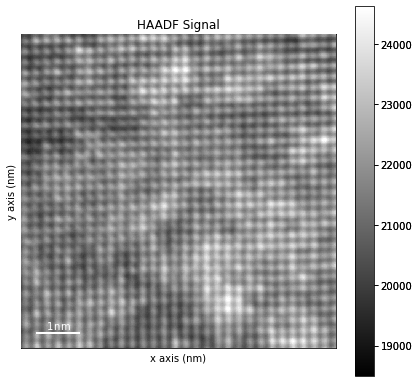

In [27]:
data[5].mean().plot(vmin=18500)

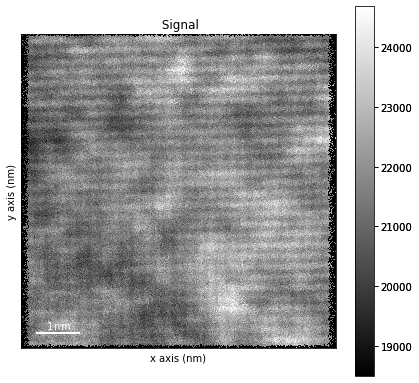

In [25]:
defim.mean().plot(vmin=18500)

In [8]:
defspec = apply_deformations_to_spectra(data[-1], numframes=5)

Processed frame 1/5
Processed frame 2/5
Processed frame 3/5
Processed frame 4/5
Processed frame 5/5


In [9]:
defspec

<LazyEDSTEMSpectrum, title: , dimensions: (512, 512|4096)>